In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [3]:
real = pd.read_parquet("results/optimized.parquet")

In [4]:
df = pd.read_csv("results/the_final_data.csv")

log2_filter = abs(df["log2_odds_ratio"]) > 0.32
sign_filter = df["p_adj"] < 0.05

df["log2_thresh"] = log2_filter
df["sign_thresh"] = sign_filter
df["both_thresh"] = log2_filter & sign_filter
df['is_gene_upregulated'] = df['log2_odds_ratio'] >= 0

import sqlite3
# add genes table
sqlite_conn = sqlite3.connect('data/mirscribe_backup.db')
genes = pd.read_sql('SELECT * FROM genes', sqlite_conn)
sqlite_conn.close()


# add genes table details
cols_to_merge = ['gene_id', 'tier_cosmic', 'is_hallmark_cosmic','is_oncogene_consensus',
       'is_tsupp_consensus']

df = pd.merge(df, genes[cols_to_merge], how="left", on="gene_id" )

dtypes = {
    'gene_id': 'string',        # More efficient than object for string data
    'tier_cosmic': 'int8',      # Small integer values
    'is_hallmark_cosmic': 'bool',
    'is_oncogene_consensus': 'bool',
    'is_tsupp_consensus': 'bool'
}

# Apply optimized dtypes:
df[cols_to_merge] = df[cols_to_merge].astype(dtypes)


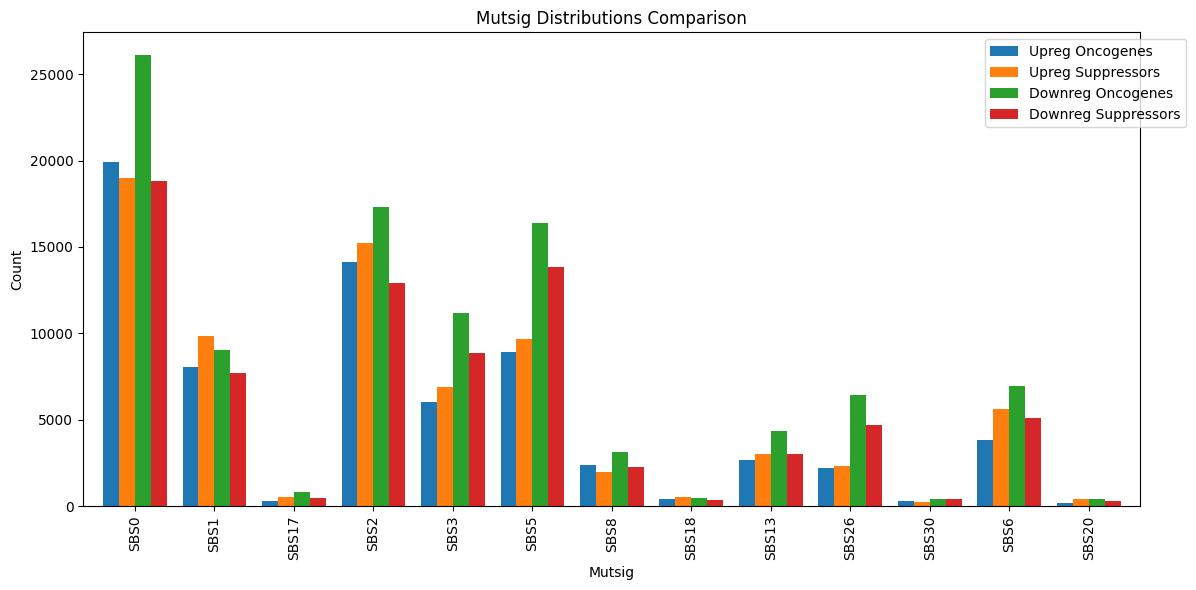

In [5]:
# Create distributions directly with correct filters
up_onc_dist = real[real.gene_id.isin(
    df[df.both_thresh & (df.log2_odds_ratio > 0) & df.is_oncogene_consensus].gene_id)].mutsig.value_counts()

up_tsupp_dist = real[real.gene_id.isin(
    df[df.both_thresh & (df.log2_odds_ratio > 0) & df.is_tsupp_consensus].gene_id)].mutsig.value_counts()

down_onc_dist = real[real.gene_id.isin(
    df[df.both_thresh & (df.log2_odds_ratio < 0) & df.is_oncogene_consensus].gene_id)].mutsig.value_counts()

down_tsupp_dist = real[real.gene_id.isin(
    df[df.both_thresh & (df.log2_odds_ratio < 0) & df.is_tsupp_consensus].gene_id)].mutsig.value_counts()

# Plot
plot_df = pd.DataFrame({
    'Upreg Oncogenes': up_onc_dist,
    'Upreg Suppressors': up_tsupp_dist,
    'Downreg Oncogenes': down_onc_dist,
    'Downreg Suppressors': down_tsupp_dist
})

ax = plot_df.plot(kind='bar', width=0.8, figsize=(12,6))
plt.xlabel('Mutsig')
plt.ylabel('Count')
plt.title('Mutsig Distributions Comparison')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


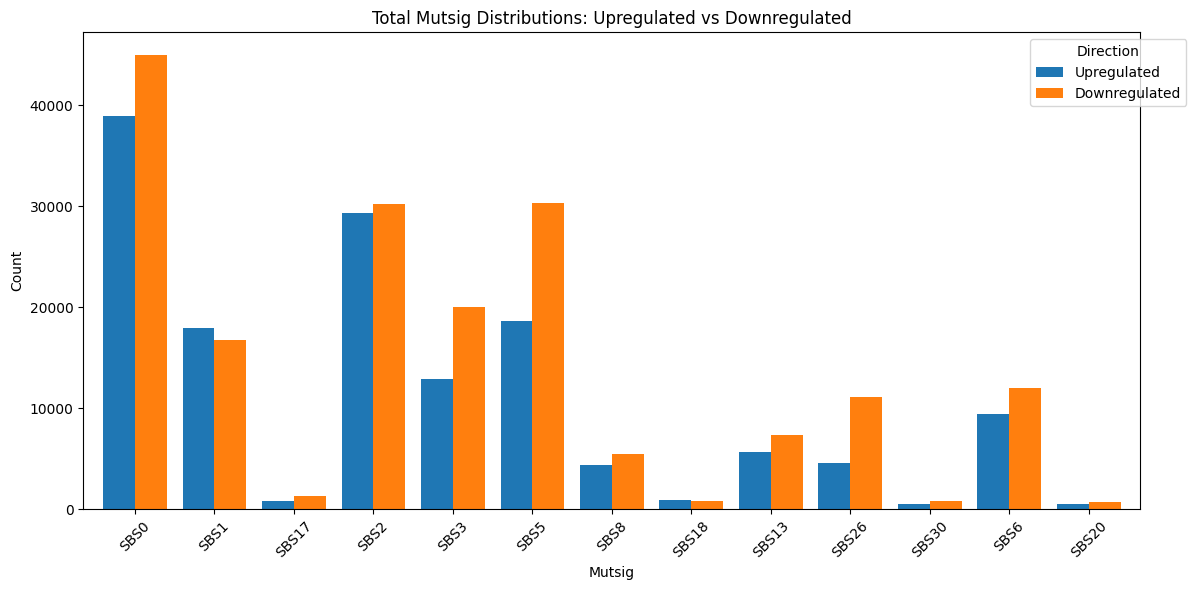

In [31]:
total_upreg = up_onc_dist.add(up_tsupp_dist, fill_value=0)
total_downreg = down_onc_dist.add(down_tsupp_dist, fill_value=0)

# Create a summary DataFrame
updown_df = pd.DataFrame({

    'Upregulated': total_upreg,
    'Downregulated': total_downreg
})


# Plot
ax = updown_df.plot(kind='bar', width=0.8, figsize=(12,6))
plt.xlabel('Mutsig')
plt.ylabel('Count')
plt.title('Total Mutsig Distributions: Upregulated vs Downregulated')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Direction', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

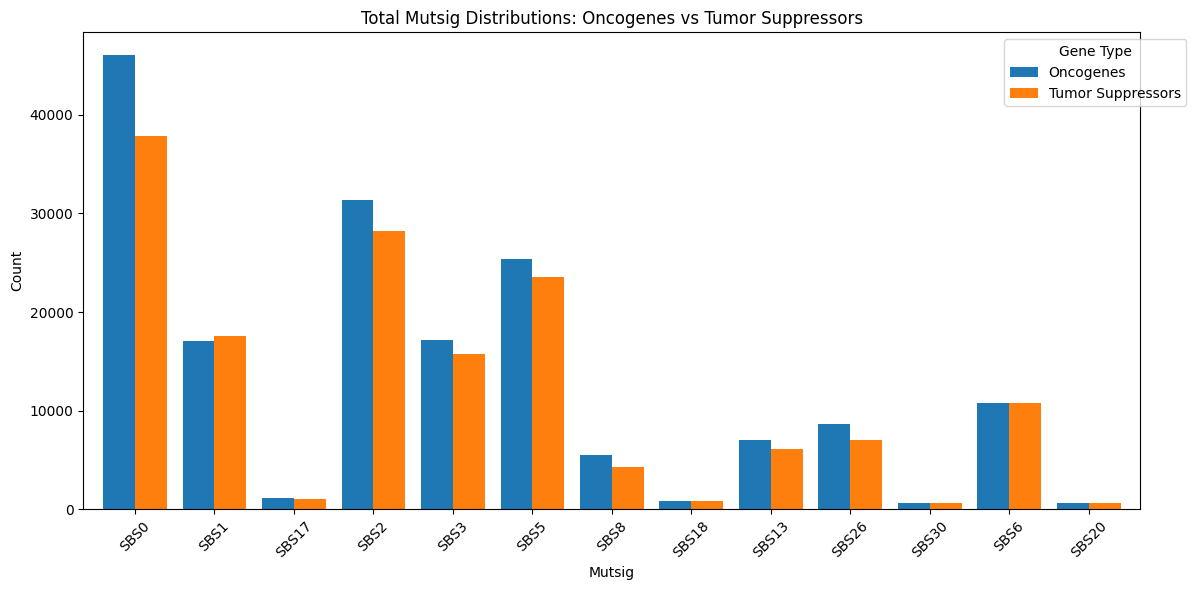

In [32]:
total_onc = up_onc_dist.add(down_onc_dist, fill_value=0)
total_tsupp = up_tsupp_dist.add(down_tsupp_dist, fill_value=0)

# Create a summary DataFrame
onctsupp_df = pd.DataFrame({
    'Oncogenes': total_onc,
    'Tumor Suppressors': total_tsupp
})

# Plot
ax = onctsupp_df.plot(kind='bar', width=0.8, figsize=(12,6))
plt.xlabel('Mutsig')
plt.ylabel('Count')
plt.title('Total Mutsig Distributions: Oncogenes vs Tumor Suppressors')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Gene Type', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


In [42]:
real[real.gene_id.isin(df[df.both_thresh & (df.log2_odds_ratio < 0)])]

,id,pred_difference,vcf_id,mirna_accession,gene_id,is_intron,is_gene_upregulated,mutsig,cancer_type,mirna_family,is_mirna_oncogene,is_mirna_tumor_suppressor,is_oncogene_consensus,is_tsupp_consensus


In [40]:
real_upreg = real[real.gene_id.isin(df[df.both_thresh & (df.log2_odds_ratio > 0)])]


In [34]:
upreg_family_pivot = real.pivot_table(index='mirna_family', columns='cancer_type', values='id', aggfunc='count')
upreg_family_pivot["sum"] = upreg_family_pivot.sum(axis=1)

upreg_family_pivot.sort_values(by="sum", ascending=False)

cancer_type,nnn,pnn,ppn,p_p,pnp,ppp,nnp,npp,p_n,npn,sum
mirna_family,,,,,,,,,,,
miR-548ay-5p/548au-5p/548as-5p/548ar-5p/548aq-5p/548ap-5p/548am-5p/548ae-5p/548ad-5p/548a-5p/548ak/548ab/548bb-5p/548b-5p/548c-5p/548d-5p/548h-5p/548i/548j-5p/548o-5p/548w/548y/559,233386,31348,170787,2725,7934,21309,42697,163,4513,3683,518545
miR-378-3p,172912,24070,126531,2084,6093,16043,34161,123,3373,2596,387986
let-7-5p/98-5p,148954,19827,107945,1678,5047,13478,28740,123,2833,2327,330952
miR-302-3p/372-3p/373-3p/520-3p,145233,19756,106337,1716,4911,13215,28188,142,2855,2283,324636
miR-17-5p/20-5p/93-5p/106-5p/519-3p,124036,16882,89233,1390,4157,11067,23413,102,2454,1811,274545
...,...,...,...,...,...,...,...,...,...,...,...
miR-423-3p,425,38,281,3,10,38,56,0,4,8,863
miR-3074-5p,323,38,207,4,11,28,51,1,3,9,675
miR-1279,274,37,192,5,7,32,61,0,1,5,614


In [15]:
mutsig_type_pivot = real.pivot_table(index='mutsig', columns='cancer_type', values='id', aggfunc='count')
mutsig_type_pivot["sum"] = mutsig_type_pivot.sum(axis=1)

mutsig_type_pivot.sort_values(by="sum", ascending=False)

cancer_type,nnn,pnn,ppn,p_p,pnp,ppp,nnp,npp,p_n,npn,sum
mutsig,,,,,,,,,,,
SBS0,10839111,1243624,6278529,74256,358265,737132,1111937,8083,218877,208142,21077956
SBS2,2148619,1438847,4711565,172879,261078,679831,2932844,0,142098,6529,12494290
SBS5,2602976,840999,5453694,21696,168506,561828,507792,12093,139648,19112,10328344
SBS3,7663229,84626,541438,0,0,12486,258634,0,1893,182608,8744914
SBS1,1935466,539637,3731144,68264,217816,762189,373833,5702,67045,21398,7722494
SBS6,2831396,0,745966,0,0,0,140104,0,0,0,3717466
SBS8,1570891,205616,1041532,3926,113810,130291,191457,2694,59134,71440,3390791
SBS26,1797358,0,1024761,0,0,0,109904,0,0,0,2932023
SBS13,554736,135959,638771,23862,0,134364,862349,0,28139,0,2378180


# insights

sbs30 and sbs20 are only specific to triple negative

In [13]:
real.head()

,id,pred_difference,vcf_id,mirna_accession,gene_id,is_intron,is_gene_upregulated,mutsig,cancer_type,mirna_family,is_mirna_oncogene,is_mirna_tumor_suppressor,is_oncogene_consensus,is_tsupp_consensus
0,0,-0.416,PD10010a,MIMAT0000257,ENSG00000172987,True,True,SBS1,nnn,miR-181-5p,False,False,False,False
1,1,-0.204,PD10010a,MIMAT0000441,ENSG00000172987,True,True,SBS1,nnn,miR-9-5p,False,False,False,False
2,2,-0.285,PD10010a,MIMAT0001635,ENSG00000172987,True,True,SBS1,nnn,miR-452-5p/892-3p,False,False,False,False
3,3,-0.507,PD10010a,MIMAT0003264,ENSG00000172987,True,True,SBS1,nnn,miR-596,False,False,False,False
4,4,0.221,PD10010a,MIMAT0003284,ENSG00000172987,True,False,SBS1,nnn,miR-371b-5p/373-5p/616-5p,False,False,False,False
